# Imports

In [1]:
%pip install tensorflow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler

def preprocess_data(df, label_col="label"):
    """
    Preprocess the DataFrame:
    - Separate labels from features.
    - Replace inf/-inf with NaN, fill NaNs with 0.
    - Remove columns with zero variance.
    - Scale features using StandardScaler.
    """
    y = df[label_col].values
    X = df.drop(columns=[label_col]).select_dtypes(include=[np.number])  # Keep numeric features

    # Handle NaN and Inf values
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Remove zero-variance features
    X = X.loc[:, X.var(axis=0) != 0]

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled



In [3]:
# Load features and labels
features = np.load('../feature_extraction_smooth/image_features.npy')  # shape: (num_images, 500)
labels = np.load('../feature_extraction_smooth/image_labels.npy')        # shape: (num_images,)






# # Normalize the features with StandardScaler
# scaler = StandardScaler()
# features = scaler.fit_transform(features)

# features= preprocess_data(features)

# Assuming labels are integers from 0 to (num_categories-1).
num_classes = len(np.unique(labels))

# Convert labels to one-hot encoding
labels_categorical = to_categorical(labels, num_classes=num_classes)

In [4]:
# Split into training and test sets (e.g., 80-20 split)
X_train, X_test, y_train, y_test = train_test_split(features, labels_categorical, test_size=0.2, stratify=labels, random_state=42)


In [5]:
from sklearn.mixture import GaussianMixture

# Determine the number of components based on unique labels
n_components = num_classes

# Apply GMM
gmm = GaussianMixture(n_components=n_components, random_state=42, max_iter=100, verbose=2)
gmm.fit(X_train)

# Print convergence status
print(f"Number of Components: {n_components}")
print(f"GMM Converged: {gmm.converged_}")

# Assign GMM cluster labels
gmm_labels_train = gmm.predict(X_train)
gmm_labels_test = gmm.predict(X_test)


Initialization 0
  Iteration 10	 time lapse 6.98498s	 ll change 0.02686
Initialization converged. time lapse 11.21415s	 lower bound 2961.97193.
Number of Components: 15
GMM Converged: True


Training KNN: 100%|██████████| 30/30 [00:00<00:00, 47.41k-value/s]


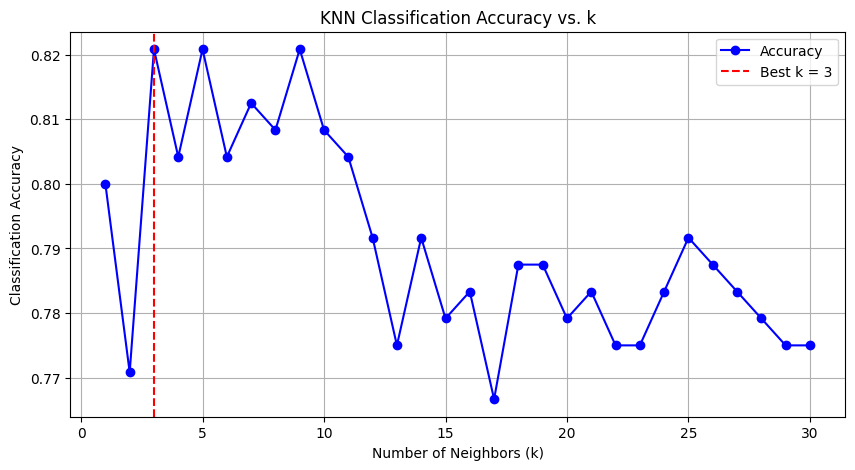

Best k: 3, Best Accuracy: 0.82


In [6]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Test k values from 1 to 30
k_values = range(1, 31)
accuracies = []

# Train KNN for different k values
with tqdm(total=len(k_values), desc="Training KNN", unit="k-value") as pbar:
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, gmm_labels_train)
        y_pred = knn.predict(X_test)
        acc = accuracy_score(gmm_labels_test, y_pred)
        accuracies.append(acc)
        pbar.update(1)

# Find the best k
best_k = k_values[np.argmax(accuracies)]
best_accuracy = max(accuracies)

# Plot accuracy vs k
plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b', label="Accuracy")
plt.axvline(best_k, color='r', linestyle='--', label=f'Best k = {best_k}')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Classification Accuracy")
plt.title("KNN Classification Accuracy vs. k")
plt.legend()
plt.grid()
plt.show()

print(f"Best k: {best_k}, Best Accuracy: {best_accuracy:.2f}")


In [7]:
# Train KNN with the best k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, gmm_labels_train)

# Predict on train and test data
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)

# Compute accuracy
accuracy_train = accuracy_score(gmm_labels_train, y_pred_train)
accuracy_test = accuracy_score(gmm_labels_test, y_pred_test)

print(f"Train Accuracy: {accuracy_train:.2f}")
print(f"Test Accuracy: {accuracy_test:.2f}")


Train Accuracy: 0.88
Test Accuracy: 0.82


In [9]:
#print classification report
from sklearn.metrics import classification_report
print("Classification Report (Train):")
print(classification_report(gmm_labels_train, y_pred_train, target_names=[str(i) for i in range(num_classes)]))
print("Classification Report (Test):")
print(classification_report(gmm_labels_test, y_pred_test, target_names=[str(i) for i in range(num_classes)]))


Classification Report (Train):
              precision    recall  f1-score   support

           0       0.73      0.95      0.83        95
           1       0.84      0.83      0.83        58
           2       0.74      0.79      0.76        76
           3       0.89      0.84      0.87        58
           4       0.97      0.97      0.97       104
           5       0.96      0.82      0.88        28
           6       0.91      0.84      0.87        80
           7       0.90      0.93      0.92        41
           8       0.87      0.77      0.82        62
           9       0.84      0.80      0.82        46
          10       0.98      0.79      0.88        53
          11       0.91      0.97      0.94       120
          12       0.98      0.93      0.96        59
          13       0.97      0.97      0.97        29
          14       0.89      0.78      0.83        51

    accuracy                           0.88       960
   macro avg       0.89      0.87      0.88      

In [ ]:
# Convert one-hot encoded labels back to their original class indices
actual_labels = np.argmax(y_test, axis=1)

# Print actual vs predicted labels
for actual, predicted in zip(actual_labels, y_pred_test):
    print(f"Actual: {actual}, Predicted: {predicted}")

#show the name of the class



Actual: 2, Predicted: 7
Actual: 11, Predicted: 11
Actual: 1, Predicted: 11
Actual: 1, Predicted: 11
Actual: 3, Predicted: 11
Actual: 6, Predicted: 11
Actual: 2, Predicted: 14
Actual: 12, Predicted: 11
Actual: 9, Predicted: 9
Actual: 3, Predicted: 1
Actual: 11, Predicted: 9
Actual: 2, Predicted: 9
Actual: 6, Predicted: 11
Actual: 7, Predicted: 11
Actual: 2, Predicted: 11
Actual: 9, Predicted: 6
Actual: 10, Predicted: 9
Actual: 3, Predicted: 7
Actual: 3, Predicted: 1
Actual: 4, Predicted: 11
Actual: 11, Predicted: 9
Actual: 0, Predicted: 11
Actual: 0, Predicted: 11
Actual: 5, Predicted: 14
Actual: 8, Predicted: 11
Actual: 1, Predicted: 0
Actual: 13, Predicted: 4
Actual: 7, Predicted: 11
Actual: 1, Predicted: 13
Actual: 2, Predicted: 14
Actual: 3, Predicted: 1
Actual: 14, Predicted: 9
Actual: 5, Predicted: 14
Actual: 11, Predicted: 11
Actual: 11, Predicted: 12
Actual: 14, Predicted: 11
Actual: 10, Predicted: 9
Actual: 3, Predicted: 1
Actual: 13, Predicted: 9
Actual: 3, Predicted: 1
Actual

In [11]:
from joblib import dump, load

# Save the trained model to a file
dump(knn, 'knn_model_smooth.joblib')

# Load the trained model from the file
loaded_knn = load('knn_model_smooth.joblib')

# Predict using the loaded model
y_pred_loaded_train = loaded_knn.predict(X_train)
accuracy_score_loaded_train = accuracy_score(gmm_labels_train, y_pred_loaded_train)
print(f"Loaded Model Train Accuracy: {accuracy_score_loaded_train:.2f}")


Loaded Model Train Accuracy: 0.88
